# Simple Variational Quantum Algorithm

In variational algorithms, the samples from a quantum circuit allow us to approximate an expectation value, which is then used to determine the value of a loss function. This loss function is chosen such that minimising it yields a solution to a given problem. By changing the values of the parameters in our quantum circuit, we can search for this minimum.

We won't go into the details of variational algorithms. However, it may be useful to see how to perform such an optimisation with Perceval.

We will use the library [scipy.optimise](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

The following code solves the problem of finding a LO-Circuit which, given a Fock State $|1,1,1,1\rangle$, maximises the probability of outputting $|4,0,0,0\rangle$.
The solution below works for an arbitrary $n$.

In [1]:
# Required imports
import numpy as np
from perceval import BasicState, BS, GenericInterferometer, SLOSBackend, Parameter, PS, Unitary, Matrix, pdisplay
from random import random
from scipy import optimize

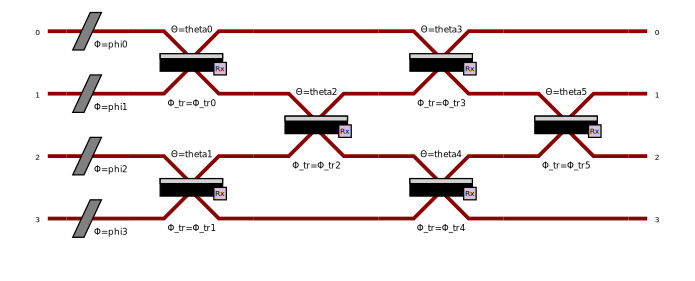

In [2]:
# Data
n = 4
input_state = BasicState([1]*n)
output_to_max = BasicState([n]+[0]*(n-1))
backend = SLOSBackend()

# We create a generic interferometer (variable parameters make it universal - i.e. it can implement any unitary transformation)
circuit = GenericInterferometer(n,
    lambda i: BS(theta=Parameter(f"theta{i}"), phi_tr=Parameter(f"phi_tr{i}")),
    phase_shifter_fun_gen=lambda i: PS(phi=Parameter(f"phi{i}")))
param_circuit = circuit.get_parameters()
params_init = [random()*np.pi for _ in param_circuit]

pdisplay(circuit)

In [3]:
# Define a loss function...
def loss_function(params):
    for i, value in enumerate(params):
        param_circuit[i].set_value(value)
    backend.set_circuit(circuit)
    backend.set_input_state(input_state)
    return - backend.probability(output_to_max)  # we want to maximise the prob, so we want to minimise the -prob

# ... and run the optimisation
o = optimize.minimize(loss_function, params_init, method="Powell")

# For n = 4, it is known that the probability should be 3/32 = 0.09375
print(f"The maximum probability is {-loss_function(o.x)}")

The maximum probability is 0.09374999999999944


In [4]:
# The maximum can also be obtained with the Hadamard matrix :
H4 = (1/2) * np.array([[1, 1, 1, 1], [1, -1, 1, -1], [1, 1, -1, -1], [1, -1, -1, 1]])
backend.set_circuit(Unitary(Matrix(H4)))
backend.set_input_state(input_state)
print(f"Using the Hadamard matrix gives {backend.probability(output_to_max)}")

Using the Hadamard matrix gives 0.09374999999999999
